## Pytorch Custom Datasets

In [121]:
# Main import statements
import torch
from torch import nn
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import os
import pathlib
from typing import List, Tuple, Dict

torch.__version__

'2.3.0+cu118'

In [3]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Get Data

Getting a dataset that is a subset from Food101 dataset.

Food101 dataset is a large dataset with 101 classes of food. We will use a subset of this dataset with 3 classes and 10% of the original dataset.

75 images per class will be used for training and 25 images per class will be used for validation.

It`s important to note that the dataset is already split into training and validation sets.

Also, when working with ML projects, it is important to start with a small dataset to test the code and the model. After that, we can increase the dataset size.

The whole point is to make sure that the code is working properly before running it on a large dataset.

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup the path for datafolder
DATA_PATH = Path("data")
image_path = DATA_PATH / "pizza_steak_sushi"

# If the image folder does not exist, download the data
if image_path.is_dir():
    print("Data already downloaded.")
else:
    print("Downloading data...")
    # Make the directory
    image_path.mkdir(parents=True, exist_ok=True)

    # Download the data
    with open(DATA_PATH / "pizza_steak_sushi.zip", "wb") as f:
        url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
        response = requests.get(url= url)
        f.write(response.content)

    # Unzip the data
    with zipfile.ZipFile(DATA_PATH / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping...")
        zip_ref.extractall(image_path)

Data already downloaded.


## 2. Data preparation and exploration

In [5]:
import os
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its directories and files
    dir_path: (str) valid path to target directory
    
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        """
        dirpath: (str) path to current directory
        dirnames: (list) list of directories in current directory
        filenames: (list) list of files in current directory
        """
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.


In [7]:
# Setup train and testing directories
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

1. Get all of image paths
2. Pick a random image path using `random.choice` function
3. Get the image class name using `pathlib.Path.parent.stem`
4. Load the image using `PIL.Image.open` function

Image path: data/pizza_steak_sushi/train/sushi/3251688.jpg
Image class: sushi
Image size: (512, 512)


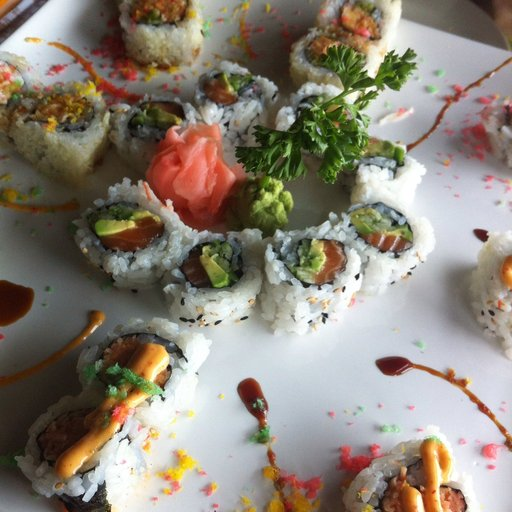

In [47]:
#1. Get all image paths
image_paths = list(image_path.glob("*/*/*.jpg")) 
# Get all images in the image_path directory (pizza_steak_sushi(image_path)/(train or test)/(pizza, steak or sushi/*.jpg)

#2. Picking a random image path
random_image_path = random.choice(image_paths)

#3. Get the image
random_image = Image.open(random_image_path)

#4. Get the class name (steak, pizza, sushi)
class_name = random_image_path.parent.name

#5. Plot the image and image metadata
print(f"Image path: {random_image_path}")
print(f"Image class: {class_name}")
print(f"Image size: {random_image.size}")
random_image

Text(0.5, 1.0, 'Image class: sushi | Image size: (512, 512, 3) -> (H, W, C)')

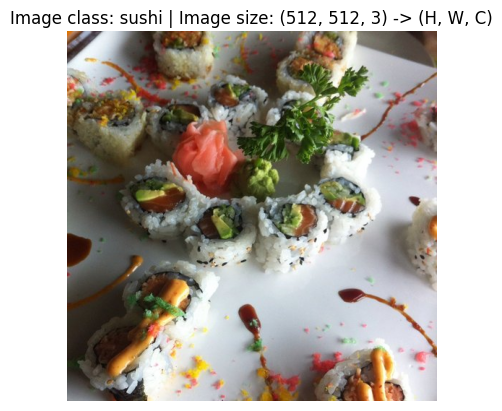

In [59]:
# Turn the image to an array
img_as_array = np.asarray(random_image)

# Plot the image with matplotlib
plt.imshow(img_as_array)
plt.axis(False)
plt.title(f"Image class: {class_name} | Image size: {img_as_array.shape} -> (H, W, C)")

## 3. Transforming data

Before feeding the data into the model, we need to apply some transformations to the data.
1. Turn the image into a tensor
2. Turn it into a `torch.utils.data.Dataset` object and subsequently into a `torch.utils.data.DataLoader` object

### 3.1 Transforming the data with `torchvision.transforms`

`torchvision.transforms` module provides a set of common image transformations. 

In [71]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize the image to 64 x 64 pixels (Copilot is suggesting 224 x 224 pixels, folowing the tutorial (64x64))
    transforms.Resize((64, 64)),
    # Flip the image horizontally with a 50% chance
    transforms.RandomHorizontalFlip(p=0.5),
    # Converts the image to a tensor
    transforms.ToTensor()
])

In [72]:
print("Image before transformation...")
print(f"Image shape: {img_as_array.shape}")
print(f"Image data type: {img_as_array.dtype}")
print("Image after transformation...")
random_image_transformed = data_transform(random_image)
print(f"Image shape: {random_image_transformed.shape}")
print(f"Image data type: {random_image_transformed.dtype}")

Image before transformation...
Image shape: (512, 512, 3)
Image data type: uint8
Image after transformation...
Image shape: torch.Size([3, 64, 64])
Image data type: torch.float32


(-0.5, 63.5, 63.5, -0.5)

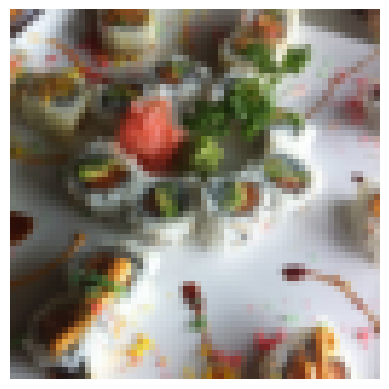

In [73]:
# Plotting the transformed image
plt.imshow(random_image_transformed.permute(1, 2, 0))
plt.axis(False)

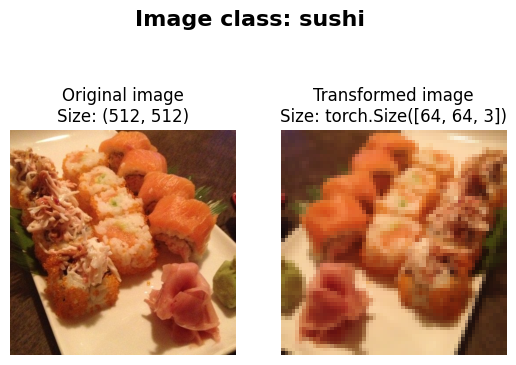

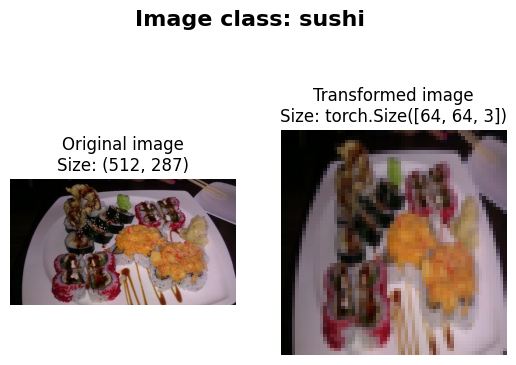

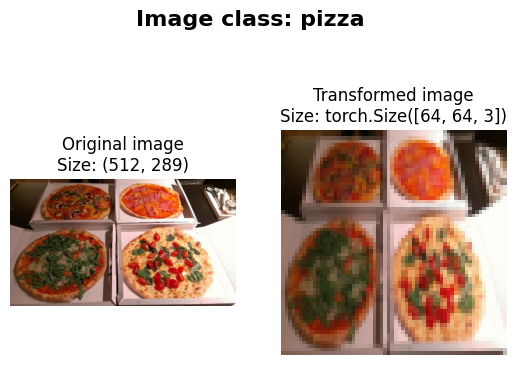

In [87]:
def plot_transformed_images(image_paths, transform, n= 3, seed= None):
    """
    Picks n random images from image_paths and applies the transform to them
    image_paths: (list) list of image paths
    transform: (callable) image transform to be applied
    n: (int) number of images to plot
    seed: (int) random seed for reproducibility
    """
    # Set the seed
    if seed:
        random.seed(seed)

    # Get n random image paths
    random_image_paths = random.sample(image_paths, n)
    
    for image_path in random_image_paths:
        with Image.open(image_path) as img:
            fig, ax = plt.subplots(1, 2)

            # Plot the original image
            ax[0].imshow(img)
            ax[0].set_title(f"Original image\nSize: {img.size}")
            ax[0].axis(False)

            # Transform the image
            transformed_img = transform(img).permute(1, 2, 0) # Change the shape from (C, H, W) to (H, W, C)

            # Plot the transformed image
            ax[1].imshow(transformed_img)
            ax[1].set_title(f"Transformed image\nSize: {transformed_img.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Image class: {image_path.parent.name}", fontsize= 16, fontweight= "bold")


# Plot the transformed images
plot_transformed_images(image_paths, transform= data_transform, seed= 42)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder` class.

In [88]:
# Use ImageFolder to create datasets
train_data = datasets.ImageFolder(root= train_dir, # Root directory of dataset (pizza_steak_sushi/train)
                                  transform= data_transform, # Converts images to tensors and apllies other transformations
                                  target_transform= None) # A transform for the labels/targets

test_data = datasets.ImageFolder(root= test_dir,
                                 transform= data_transform,
                                 target_transform= None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [89]:
# Get the class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [91]:
# Get class names as dictionary
class_names_dict = train_data.class_to_idx
class_names_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [92]:
# Check the length of the training and testing data
len(train_data), len(test_data)

(225, 75)

In [96]:
# Getting a single image and its label
img, label = train_data[0]
img.shape, class_names[label]

(torch.Size([3, 64, 64]), 'pizza')

Image shape: torch.Size([3, 64, 64])
Image shape (permuted): torch.Size([64, 64, 3])


(-0.5, 63.5, 63.5, -0.5)

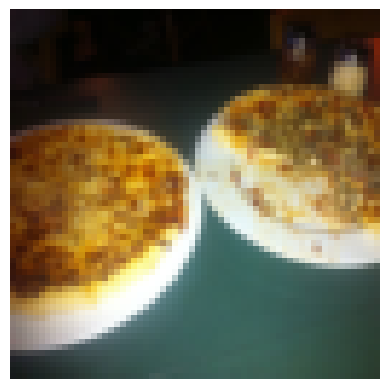

In [101]:
# Rearrange the order of the image tensor
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Image shape: {img.shape}")
print(f"Image shape (permuted): {img_permute.shape}")

# Plot the image
plt.imshow(img_permute)
plt.axis(False)

### 4.1 Turn the data into DataLoader

The Dataloader turns the datasets into iterable objects that can be used to train the model.

We can also customise the `batch_size` so our model can look at multiple images at once.

In [111]:
import os

# Setting the batch size
BATCH_SIZE = 1

# Turn train and test datasets into DataLoader
train_loader = DataLoader(dataset= train_data,
                          batch_size= BATCH_SIZE,
                          shuffle= True,
                          num_workers=2) # Number of processes to use to prepare the data. `os.cpu_count()` returns the number of logical CPUs in the system

test_loader = DataLoader(dataset= test_data,
                            batch_size= BATCH_SIZE,
                            shuffle= False,
                            num_workers=1)
len(train_loader), len(test_loader)

(225, 75)

In [113]:
# Getting the first iterable batch of images and labels
imgs, labels = next(iter(train_loader))

# Check the shape of the images
print(f"Images shape: {imgs.shape} -> (batch_size, channels, height, width)")
print(f"Labels shape: {labels.shape} -> (batch_size)")

Images shape: torch.Size([1, 3, 64, 64]) -> (batch_size, channels, height, width)
Labels shape: torch.Size([1]) -> (batch_size)


## 5. Option 2: Creating a custom dataset

1. Must be able to load images from file
2. Must be able to load the image label from the Dataset
3. Must be able to return classes as dictionary from Dataset

Pros:
* Can create a custom dataset with any data
* Not limited to PyTorch pre-built dataset functions

Cons:
* More work to implement
* Will leed to more code, often leding to potential bugs

In [116]:
# Insatance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We will create a helper function to get the class names from the dataset.
1. Get the class names using `os.scan_dir` function to traverse the target directory.
2. Raise an error if the class names are not found.
3. Turn the class names into a dict and a list and return them.

In [119]:
# Setup path for target directory
target_directory = train_dir

# Get the class names from the target directory
class_names_found = sorted([target.name for target in os.scandir(target_directory) if target.is_dir()])
class_names_found

['pizza', 'steak', 'sushi']

In [120]:
def find_classes(dir_path: str) -> Tuple[List[str], Dict[str, int]]:
    """
    Finds the class folders in a dataset
    dir_path: (str) valid path to target directory
    """
    classes = [d.name for d in os.scandir(dir_path) if d.is_dir()]
    classes.sort()
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

# Get the class names and class to index mapping
class_names, class_to_idx = find_classes(target_directory)
class_names, class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Creating a custom dataset

To create our own custom dataset, we need to:

1. Inherit from `torch.utils.data.Dataset` class.
2. Init our subclass with a target directory and a transform.
3. Create several attributes:
    * `self.image_paths` to store the image paths
    * `self.transform` to store the transform
    * `self.class_names` to store the class names
    * `self.class_name_to_idx` to store the class name to index mapping
4. Create a function to `load_images()`
5. Overwrite the `__len__` function to return the length of the dataset
6. Overwrite the `__getitem__` function to return the image and the label

In [156]:
# Write a custom dataset

# Subclassing torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # Initializing our custom dataset
    def __init__(self, target_directory: str, transform= None):
        """
        target_directory: (str) path to the target directory
        transform: (callable) image transform to be applied
        """

        # Creating class attributes
        self.image_paths = list(pathlib.Path(target_directory).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(target_directory)

    # Create a funtion to load an image
    def load_image(self, index: int) -> Image.Image:
        """
        Opens an image from a file path and returns it
        index: (int) index of the image to be retrieved
        """
        image_path = self.image_paths[index]
        return Image.open(image_path)

    # Get the length of the dataset
    def __len__(self) -> int:
        """
        Returns the total number of samples.
        """
        return len(self.image_paths)

    # Get an image and its label
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """
        Retrieves an image and its label from the dataset
        index: (int) index of the image to be retrieved
        """
        image = self.load_image(index)
        class_name = self.image_paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        if self.transform:
            image = self.transform(image)
        return image, class_idx

In [157]:
# Create a transform
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])



In [158]:
# Create an instance of ImageFolderCustom
train_data_custom = ImageFolderCustom(train_dir, transform= train_transform)
test_data_custom = ImageFolderCustom(test_dir, transform= test_transform)

In [159]:
# Comparing the custom dataset with the original dataset
len(train_data_custom), len(train_data)

(225, 225)

In [160]:
len(test_data_custom), len(test_data)

(75, 75)

In [161]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [162]:
train_data_custom.class_to_idx, train_data.class_to_idx

({'pizza': 0, 'steak': 1, 'sushi': 2}, {'pizza': 0, 'steak': 1, 'sushi': 2})

In [163]:
# Checking for equality
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True


### 5.3 Create a function to visualize random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to display.
2. To prevent the function from running indefinitely, we will set a maximum number of iterations.
3. Set a random seed for reproductibility.
4. Get a list of random sample indexes from the dataset.
5. Iterate over the indexes and display the images.

In [174]:
# Create a function to take in a dataset
def display_random_images(dataset: Dataset,
                          classes: List[str],
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    # Adjusting display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print("Can't display more than 10 images.")

    # Set the seed
    if seed:
        random.seed(seed)

    # Get random samples
    random_images_idx = random.sample(range(len(dataset)), n)

    # Setup plot
    plt.figure(figsize=(16, 8))


    # Loop through the indexes and plot them
    for i, idx in enumerate(random_images_idx):
        img, label = dataset[idx]
        img_permute = img.permute(1, 2, 0) # Always remember to adjust the shape of the image tensor for matplotlib. (C, H, W) -> (H, W, C)

        # Plot the image
        plt.subplot(1, n, i+1)
        plt.imshow(img_permute)
        plt.axis(False)

        if classes:
            title = f"class: {classes[label]}"

            # Add title if display_shape is True
            if display_shape:
                title = title + f"\nshape: {img_permute.shape}"
            
        plt.title(title)
        

        



    

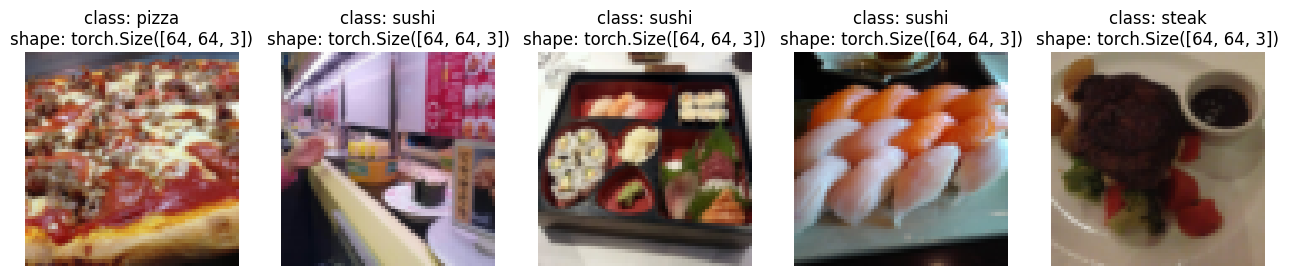

In [176]:
display_random_images(train_data,classes=train_data.classes, n= 5)

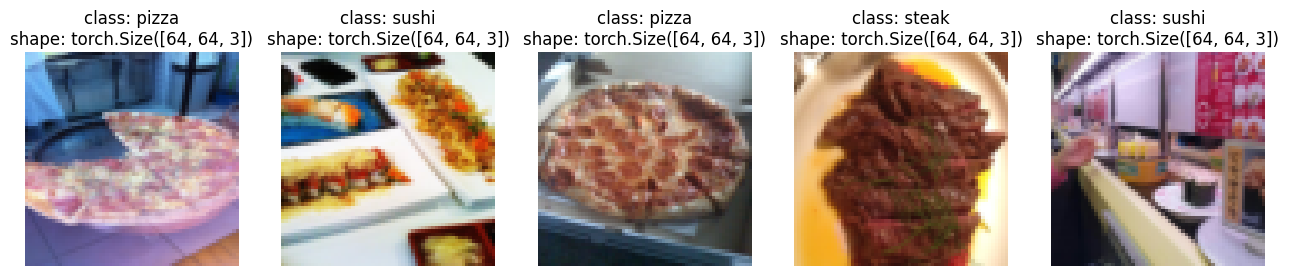

In [177]:
 display_random_images(train_data_custom, classes= train_data_custom.classes, n= 5)

### 5.4 Turn custom dataset into DataLoader

In [181]:
BATCH_SIZE = 32
NUM_WORKERS = 2
train_dataloader_custom = DataLoader(dataset= train_data_custom,
                                     batch_size= BATCH_SIZE,
                                     shuffle= True,
                                     num_workers= NUM_WORKERS)

test_dataloader_custom = DataLoader(dataset= test_data_custom,
                                    batch_size= BATCH_SIZE,
                                    shuffle= False,
                                    num_workers= NUM_WORKERS)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f6196cbc080>,
 <torch.utils.data.dataloader.DataLoader at 0x7f6196cbdbe0>)

In [183]:
# Get image and label from custom dataloader
imgs, labels = next(iter(train_dataloader_custom))

# Check the shape of the images
print(f"Images shape: {imgs.shape} -> (batch_size, channels, height, width)")
print(f"Labels shape: {labels.shape} -> (batch_size)")

Images shape: torch.Size([32, 3, 64, 64]) -> (batch_size, channels, height, width)
Labels shape: torch.Size([32]) -> (batch_size)


## 6. Other forms of transforms -> Data Augmentation

Data augmentation is a technique used to increase the diversity of your training set by applying random (but realistic) transformations to your training images. 
This helps your model generalize better to the unseen data.

In the case of image data, this may include: 
* rotation
* flipping
* scaling
* cropping.

This practice hopefully results in a model that is more robust and invariant to these changes during training.

In [ ]:
# Let's look at one type of data augmentation: trivialaugment
train_transform_trivial = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins= 31), # Copilot is suggesting 15, but following the tutorial (31)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0), ratio=(0.75, 1.333)),
    transforms.ToTensor()
])
